# LunarLander-v2 solver
## 1. Functions and classes
Import packages, network class setup

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import gym
import gym.spaces as sp
from tqdm import tqdm
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#%% Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, layer_dims):
        super(QNet, self).__init__()

        # self.fc = nn.Sequential(
        #     nn.Linear(n_states, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_actions)
        #     )
        self.linears = nn.ModuleList([nn.Linear(layer_dims[i], layer_dims[i+1]) for i in range(0, len(layer_dims)-1)])
        self.act = torch.nn.ReLU()

    def forward(self, x):
        # return self.fc(x)
        hid = self.act(self.linears[0](x))
        for li in self.linears[1:-1]:
            hid = self.act(li(hid))
        return F.softmax(self.linears[-1](hid), dim=-1)

#%% dqn    
class DQN():
    def __init__(self, n_states, n_actions, layer_dims, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_eval = QNet(n_states, n_actions, layer_dims).to(device)
        self.net_target = QNet(n_states, n_actions, layer_dims).to(device)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)


class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

## Traning and Testing functions

In [27]:
def train(env, agent, writer, n_episodes=2000, ep_per_batch = 7, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200, chkpt=False):
    score_hist = []
    epsilon = eps_start
    avg_total_rewards, avg_final_rewards = [], []

    # bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = tqdm(range(n_episodes))
    for idx_epi in pbar:
        total_rewards, final_rewards = [], []
        
        for epi in range(ep_per_batch):
            state, _ = env.reset()
            score = 0
            total_reward = 0
            
            DONE = False
            # for idx_step in range(max_steps):
            while not DONE:
                action = agent.getAction(state, epsilon)
                next_state, reward, terminated, truncated, _ = env.step(action)
                agent.save2memory(state, action, reward, next_state, DONE)
                state = next_state
                total_reward += reward
                DONE = terminated or truncated

            # score_hist.append(score)
            # score_avg = np.mean(score_hist[-100:])
            final_rewards.append(reward)
            total_rewards.append(total_reward)
            epsilon = max(eps_end, epsilon*eps_decay)

        avg_total_reward = sum(total_rewards) / len(total_rewards)
        avg_final_reward = sum(final_rewards) / len(final_rewards)
        
        writer.add_scalar('avg_total_reward', avg_total_reward, idx_epi)
        writer.add_scalar('avg_final_reward', avg_final_reward, idx_epi)
        
        avg_total_rewards.append(avg_total_reward)
        avg_final_rewards.append(avg_final_reward)
        pbar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")
            # pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
            # pbar.update(0)

        # if (idx_epi+1) % 100 == 0:
        #     print(" ")
        #     sleep(0.1)

        # Early stop
        if avg_total_reward >= target:
            print('Early stopped!')
            break

    # if (idx_epi+1) < n_episodes:
    #     print("\nTarget Reached!")
    # else:
    #     print("\nDone!")
        
    # if chkpt:
    #     torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return avg_total_rewards

#%% Test Lunar Lander
def testLander(env, agent, loop=3):
    for i in range(loop):
        state = env.reset()
        for idx_step in range(500):
            action = agent.getAction(state, epsilon=0)
            env.render()
            state, reward, done, _ = env.step(action)
            if done:
                break
    env.close()
    
def plotScore(scores):
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.show()

## 2. Train the network

  0%|          | 0/500 [00:00<?, ?it/s]

Total: -248.8, Final: -100.0: 100%|██████████| 500/500 [19:44<00:00,  2.37s/it]


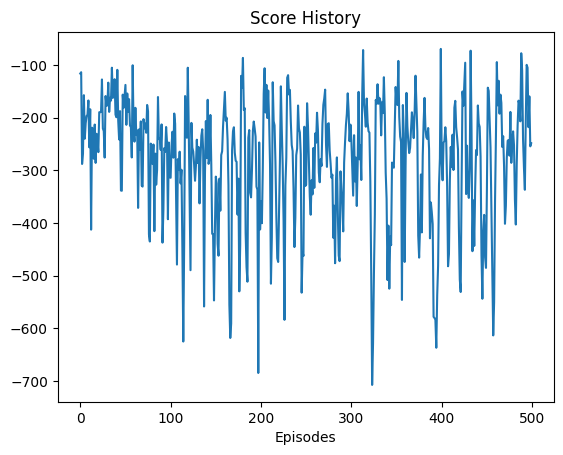

In [32]:
from torch.utils.tensorboard import SummaryWriter


BATCH_SIZE = 256
LR = 1e-4
EPISODES = 500
EPISODE_PER_BATCH = 5
TARGET_SCORE = 80.     # early training stop at avg score of last 100 episodes
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = False      # save trained network .pth file

layer_dims = [8, 16, 16, 4]      # default: [8, 64, 4]

env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    layer_dims = layer_dims,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )
writer = SummaryWriter(f'runs/DQN-{"-".join(str(x) for x in [layer_dims])}-{BATCH_SIZE}-{EPISODES}-{EPISODE_PER_BATCH}')
score_hist = train(env, agent, writer, n_episodes=EPISODES, ep_per_batch=EPISODE_PER_BATCH, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
plotScore(score_hist)

# if str(device) == "cuda":
#     torch.cuda.empty_cache()

## 4. Test the LunarLander!
Run code below to test trained result

In [ ]:
testLander(env, agent, loop=10)